In [1]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unicodedata
import contractions
import string


In [2]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime
import tqdm


%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

In [3]:
def preprocess_corpus(text):
    """Preprocesses sports news text for CNN.

    Args:
        text (str): The input text.

    Returns:
        str: The preprocessed text.
    """

    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Convert to lowercase
    text = text.lower()


    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]


    # Join words into a sentence
    preprocessed_text = ' '.join(words)

    return preprocessed_text



### Load Dataset (Drug Reviews):

In [27]:
#https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

In [4]:
#Reading DAtaset from csv files to Pandas dataframes

drugs_df_train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
drugs_df_test = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

In [5]:
print(drugs_df_train.columns)
print(drugs_df_test.columns)

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')


In [6]:
drugs_df_train.dtypes

Unnamed: 0      int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [7]:
drugs_df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37


In [8]:
drugs_df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4


In [9]:
drugs_df_train.shape

(161297, 7)

In [10]:
drugs_df_test.shape

(53766, 7)

In [11]:
drugs_df_train.dtypes

Unnamed: 0      int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [12]:
drugs_df_train.rating.describe()

count    161297.000000
mean          6.994377
std           3.272329
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Combine train and test data for splitting
combined_df = pd.concat([drugs_df_train, drugs_df_test], ignore_index=True)

# Split combined data into new train and validation sets
train_df_new, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)

### Data preparation for the CNN Model

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Preprocess text (using the function you defined earlier)
train_df_new['review'] = train_df_new['review'].apply(preprocess_corpus)
drugs_df_test['review'] = drugs_df_test['review'].apply(preprocess_corpus)
val_df['review'] = val_df['review'].apply(preprocess_corpus)




C:\Users\1508\AppData\Local\Temp\ipykernel_16412\3827392496.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Preprocessing and Tokenization

In [15]:
X_train = train_df_new['review'].values
y_train = train_df_new['rating'].values

X_test = drugs_df_test['review'].values
y_test = drugs_df_test['rating'].values


X_val = val_df['review'].values
y_val = val_df['rating'].values

In [16]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [17]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

### Dataset Visualization

In [18]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=67535
Number of Reviews=172050


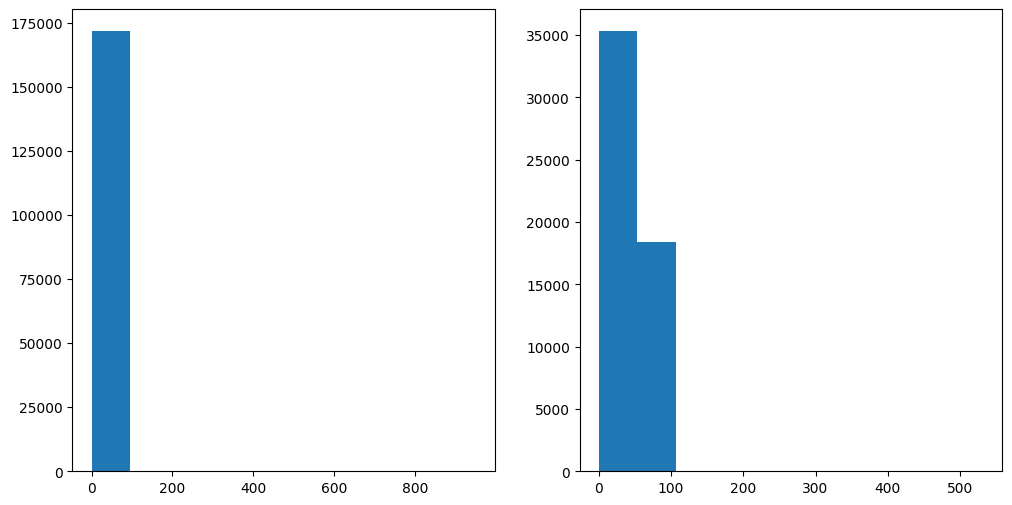

In [19]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization and Encoding Labels

In [20]:
# Padding the dataset to a maximum review length in words

MAX_SEQUENCE_LENGTH = 40

X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
# Encoding Labels

le = LabelEncoder()
num_classes=10 

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

### Model Preparation and Training

In [22]:
# Setting Vocabulary size and Emmbedding size

VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 40

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 2

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [23]:
# Creating the model

model = Sequential()
# The Embedding layer
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# The first one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
# The first Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The first Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The second one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The second Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The second Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The third one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The third Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The third Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The Flattening layer
model.add(Flatten())
# The First Dense Layer (256,relu)
model.add(Dense(256, activation='relu'))
# The Second Dense Layer or Prediction layer (1,sigmoid)
model.add(Dense(10, activation='softmax'))
# Compiling the Model using the Binary_Crossontropy as a loss function and accuracy as a meseaure and Adam as an Optimizer
model.compile(loss='SparseCategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
# Displaying the Model Schema
model.summary()

c:\Users\1508\AppData\Local\anaconda31\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 117s 41ms/step - accuracy: 0.3440 - loss: 1.9061 - val_accuracy: 0.4034 - val_loss: 1.6908
Epoch 2/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 150s 56ms/step - accuracy: 0.4157 - loss: 1.6383 - val_accuracy: 0.4242 - val_loss: 1.6000
Epoch 3/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 115s 43ms/step - accuracy: 0.4524 - loss: 1.5093 - val_accuracy: 0.4365 - val_loss: 1.5581
Epoch 4/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 113s 42ms/step - accuracy: 0.4873 - loss: 1.3891 - val_accuracy: 0.4491 - val_loss: 1.5284
Epoch 5/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 117s 43ms/step - accuracy: 0.5244 - loss: 1.2773 - val_accuracy: 0.4674 - val_loss: 1.5209
Epoch 6/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 109s 40ms/step - accuracy: 0.5649 - loss: 1.1709 - val_accuracy: 0.4744 - val_loss: 1.5237
Epoch 7/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.6065 - loss: 1.0688 - val_accuracy: 0.4845 - val_loss: 1.5447
Epoch 8/10
2689/2689 ━━━━━━━━━━━━━━━━━━━━ 104s 39ms/step - accuracy: 

### Visualizing and Evaluating the Results

In [25]:
# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1681/1681 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7174 - loss: 0.8627
Accuracy: 71.79%


In [26]:
history1

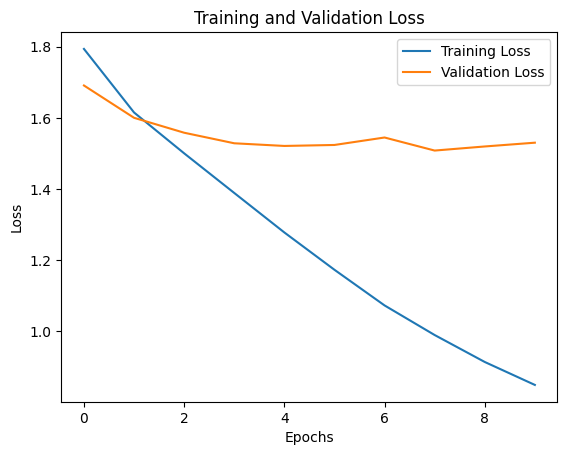

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show() 


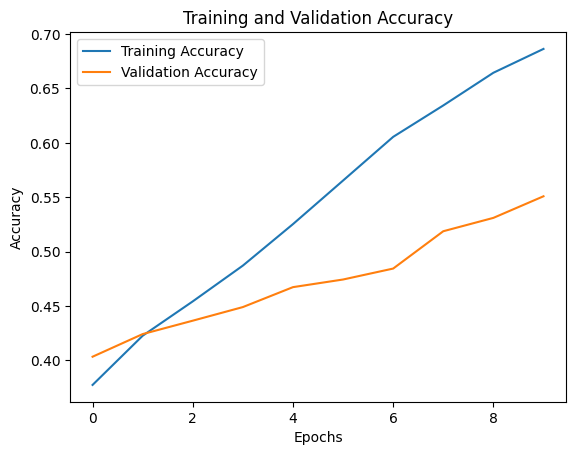

In [28]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Creating and Visualizing a Confusion Matrix

1681/1681 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      7299
           1       0.58      0.37      0.45      2334
           2       0.43      0.48      0.45      2205
           3       0.49      0.21      0.29      1659
           4       0.45      0.59      0.51      2710
           5       0.50      0.31      0.38      2119
           6       0.63      0.50      0.56      3091
           7       0.64      0.68      0.66      6156
           8       0.74      0.72      0.73      9177
           9       0.85      0.89      0.87     17016

    accuracy                           0.72     53766
   macro avg       0.61      0.57      0.57     53766
weighted avg       0.71      0.72      0.71     53766



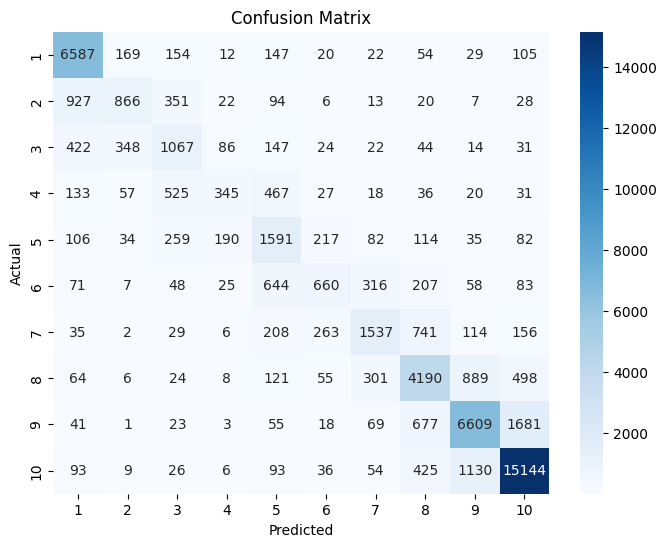

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your predicted labels (y_pred) and true labels (y_true)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5,6,7,8,9,10], yticklabels=[1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()